In [9]:
# Import our dependencies
import pandas as pd
import matplotlib as plt
import sklearn as skl
import tensorflow as tf
from sklearn.datasets import make_circles

# Creating dummy nonlinear data
X_circles, y_circles = make_circles(n_samples=1000, noise=0.05, random_state=78)

# Transforming y_circles to a vertical vector
y_circles = y_circles.reshape(-1, 1)

# Use sklearn to split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_circles, y_circles, random_state=78)

# Create scaler instance
X_scaler = skl.preprocessing.StandardScaler()

# Fit the scaler
X_scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


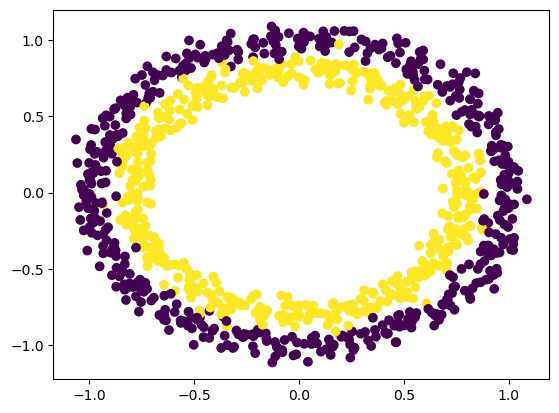

In [ ]:
# Creating a DataFrame to plot the nonlinear dummy data
circles_df = pd.get_dummies(pd.DataFrame(X_circles, columns=["X0", "X1"]))
circles_df["target"] = y_circles

# Plot the nonlinear dummy data
import matplotlib.pyplot as plt
plt.scatter(circles_df["X0"], circles_df["X1"], c=circles_df["target"], colormap = 'winter')

In [20]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    # Create the Sequential model instance
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=30,
        step=2), activation=activation, input_dim=2))
    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 10)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=30,
            step=2), activation=activation))
        
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return nn_model


In [21]:
# Import the kerastuner library
import keras_tuner as kt

# Create a `Hyperband()` tuner instance
tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=100,
    factor=3,
    directory="keras_tuner",
    project_name="intro_to_kt")


In [22]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=100,validation_data=(X_test_scaled,y_test))


Trial 59 Complete [00h 00m 28s]
val_accuracy: 0.40799999237060547

Best val_accuracy So Far: 0.5920000076293945
Total elapsed time: 00h 09m 22s

Search: Running Trial #60

Value             |Best Value So Far |Hyperparameter
sigmoid           |sigmoid           |activation
13                |19                |first_units
9                 |3                 |num_layers
17                |25                |units_0
29                |1                 |units_1
3                 |1                 |units_2
13                |None              |units_3
17                |None              |units_4
9                 |None              |units_5
7                 |None              |units_6
1                 |None              |units_7
1                 |None              |units_8
25                |None              |units_9
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0     

In [ ]:
# Get top 3 model hyperparameters and print the values
top_hyper = tuner.get_best_hyperparameters(3)


In [ ]:
# Evaluate the top 3 models against the test dataset
for hyper in top_hyper:
    # Create the model instance
    model = tuner.hypermodel.build(hyper)
    
    # Fit the model to the training data
    model.fit(X_train_scaled,y_train,epochs=100,validation_data=(X_test_scaled,y_test))
    
    # Evaluate the model against the test dataset
    model_loss, model_accuracy = model.evaluate(X_test_scaled,y_test,verbose=2)
    
    # Print out the model accuracy
    print(f"Model Accuracy: {model_accuracy}")


In [ ]:
# Get second best model hyperparameters
second_best = tuner.get_best_hyperparameters(1)[0]


In [ ]:
# Compare the performance to the second-best model
model = tuner.hypermodel.build(second_best)
